In [1]:
import pandas as pd
import pickle as pkl
import numpy as np

# pull in data

## Cispd data

In [2]:
allResults = pkl.load(open("/n/scratch2/ms994/allZeData.pkl", "rb"))

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
labels =  pd.read_csv("/home/ms994/beat_pd/data/cis-pd/data_labels/CIS-PD_Training_Data_IDs_Labels.csv")

In [4]:
train_mid, test_mid = train_test_split(labels.measurement_id.unique(), random_state=1)

In [5]:
train_mid, valid_mid = train_test_split(train_mid, random_state=1)

In [6]:
all_mid = sorted(labels.measurement_id)

In [7]:
train_indices  = [all_mid.index(train_m) for train_m in train_mid]
valid_indices  = [all_mid.index(train_m) for train_m in valid_mid]
test_indices  = [all_mid.index(train_m) for train_m in test_mid]

In [8]:
x = np.array([res[0] for res in allResults])

In [9]:
y = [res[1] for res in allResults]

In [10]:
y = pd.concat(y)

In [11]:
x_std = x.std(axis=1)

In [12]:
x_std = np.nan_to_num(x_std)

In [13]:
mask = ~(pd.isnull(y["tremor"]) | pd.isnull(y["dyskinesia"]) | pd.isnull(y["on_off"]) | (x_std < 0.05).all(1))

In [14]:
x.shape

(204098, 1501, 3)

In [15]:
x[mask].shape

(65545, 1501, 3)

In [16]:
x = x[mask]

In [17]:
y = y[mask]

In [18]:
x = x[:,:1500]

In [19]:
all_m_id = sorted(y.measurement_id.unique())

In [20]:
train_mask = y.measurement_id.isin(train_mid) 

In [21]:
y_train = y[train_mask]

In [22]:
x_train = x[train_mask]

In [23]:
x_train.shape

(36987, 1500, 3)

In [24]:
valid_mask = y.measurement_id.isin(valid_mid)

In [25]:
y_valid = y[valid_mask]
x_valid = x[valid_mask]

# all 3 outputs

In [26]:
import keras
num_cnn_layers = 5
num_lstm_layers = 2
num_lin_layers = 2
inputLayer = keras.layers.Input((1500, 3))
x = inputLayer


for i in range(num_cnn_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(16, (3,), padding="same")(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool1D((2,))(x)
for j in range(num_lstm_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.CuDNNLSTM(256, return_sequences=True)(x)
    x = keras.layers.LeakyReLU()(x)


x = keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x = keras.layers.Dense(200)(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.5)(x)

x_shared_flattened = x

#one_off
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(256)(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1)(x)
x_on_off = keras.layers.ReLU(name="on_off", max_value=4)(x)

#tremor
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(256)(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1)(x)
x_dyskinesia = keras.layers.ReLU(name="dyskinesia", max_value=4)(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(256)(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1)(x)
x_tremor = keras.layers.ReLU(name="tremor", max_value=4)(x)



model = keras.Model(inputs=inputLayer, outputs=[x_on_off, x_dyskinesia, x_tremor])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [27]:
model.compile("adam", loss=["mean_squared_error", "mean_squared_error","mean_squared_error", ])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 1500, 3)      12          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1500, 16)     160         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 1500, 16)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [28]:
def train_gen():
    i = 0
    total_num_instances = x_train.shape[0]
    while True:
        yield x_train[i], y_train.on_off.values[i]

In [28]:
modelCheckpoint = keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnnlstm3.h5", save_best_only=True, verbose=True)
reduceLR = keras.callbacks.ReduceLROnPlateau(patience=5, verbose=True)
earlyStopping = keras.callbacks.EarlyStopping(patience=20, min_delta=0.01)
lr_schedule = keras.callbacks.LearningRateScheduler(lambda i, lr: lr*0.8)
history = model.fit(x=x_train, y=[y_train.on_off.values, y_train.dyskinesia.values, y_train.tremor.values], validation_data=(x_valid, [y_valid.on_off.values, y_valid.dyskinesia.values,y_valid.tremor.values]), callbacks=[earlyStopping, lr_schedule, modelCheckpoint], epochs=200, batch_size=128)

Instructions for updating:
Use tf.cast instead.
Train on 36987 samples, validate on 12434 samples
Epoch 1/200
36987/36987 [==============================] - 46s 1ms/step - loss: 3.9717 - on_off_loss: 1.9828 - dyskinesia_loss: 0.9690 - tremor_loss: 1.0199 - val_loss: 3.2184 - val_on_off_loss: 1.7622 - val_dyskinesia_loss: 0.6871 - val_tremor_loss: 0.7691

Epoch 00001: val_loss improved from inf to 3.21838, saving model to /n/scratch2/ms994/cnnlstm3.h5
Epoch 2/200
36987/36987 [==============================] - 25s 681us/step - loss: 3.4974 - on_off_loss: 1.7552 - dyskinesia_loss: 0.8419 - tremor_loss: 0.9003 - val_loss: 3.3114 - val_on_off_loss: 1.6908 - val_dyskinesia_loss: 0.7507 - val_tremor_loss: 0.8698

Epoch 00002: val_loss did not improve from 3.21838
Epoch 3/200
36987/36987 [==============================] - 25s 676us/step - loss: 3.7692 - on_off_loss: 1.8286 - dyskinesia_loss: 0.9202 - tremor_loss: 1.0204 - val_loss: 3.2447 - val_on_off_loss: 1.7535 - val_dyskinesia_loss: 0.7168

36987/36987 [==============================] - 25s 676us/step - loss: 2.6044 - on_off_loss: 1.3395 - dyskinesia_loss: 0.5969 - tremor_loss: 0.6680 - val_loss: 3.0658 - val_on_off_loss: 1.6731 - val_dyskinesia_loss: 0.6576 - val_tremor_loss: 0.7351

Epoch 00025: val_loss did not improve from 3.01154
Epoch 26/200
36987/36987 [==============================] - 25s 675us/step - loss: 2.5989 - on_off_loss: 1.3341 - dyskinesia_loss: 0.5971 - tremor_loss: 0.6677 - val_loss: 3.0688 - val_on_off_loss: 1.6756 - val_dyskinesia_loss: 0.6584 - val_tremor_loss: 0.7347

Epoch 00026: val_loss did not improve from 3.01154
Epoch 27/200
36987/36987 [==============================] - 25s 676us/step - loss: 2.5902 - on_off_loss: 1.3292 - dyskinesia_loss: 0.5960 - tremor_loss: 0.6650 - val_loss: 3.0727 - val_on_off_loss: 1.6775 - val_dyskinesia_loss: 0.6597 - val_tremor_loss: 0.7356

Epoch 00027: val_loss did not improve from 3.01154
Epoch 28/200
36987/36987 [==============================] - 25s 671us/step

In [29]:
model = keras.models.load_model("/n/scratch2/ms994/cnnlstm3.h5")

In [30]:
model.predict(x_valid)

[array([[0.52982676],
        [0.5838137 ],
        [0.55122524],
        ...,
        [0.9598573 ],
        [0.9648749 ],
        [0.9970462 ]], dtype=float32), array([[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.21395937],
        [0.20995823],
        [0.22505549]], dtype=float32), array([[0.0378248 ],
        [0.04636757],
        [0.        ],
        ...,
        [1.1494902 ],
        [1.147995  ],
        [1.1570262 ]], dtype=float32)]

In [31]:
predictions = model.predict(x_valid)

In [32]:
import matplotlib.pyplot as plt

(array([1023.,  458., 1623., 2371., 2099., 2150., 1599.,  783.,  297.,
          31.]),
 array([0.        , 0.26422903, 0.52845806, 0.7926871 , 1.0569161 ,
        1.3211452 , 1.5853742 , 1.8496033 , 2.1138322 , 2.3780613 ,
        2.6422904 ], dtype=float32),
 <a list of 10 Patch objects>)

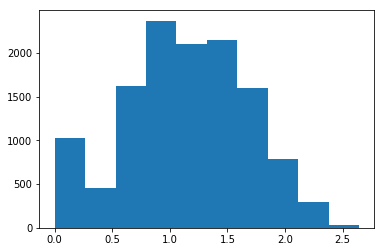

In [33]:
plt.hist(predictions[0])

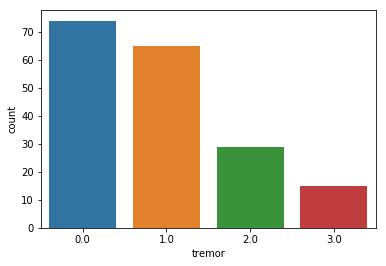

In [281]:
import seaborn as sns
sns.countplot(y_valid.groupby("measurement_id").mean()["tremor"])

(array([4669., 1303., 1049., 1324., 1981., 1485.,  550.,   45.,   21.,
           7.]),
 array([0.        , 0.25464985, 0.5092997 , 0.7639496 , 1.0185994 ,
        1.2732493 , 1.5278991 , 1.782549  , 2.0371988 , 2.2918487 ,
        2.5464985 ], dtype=float32),
 <a list of 10 Patch objects>)

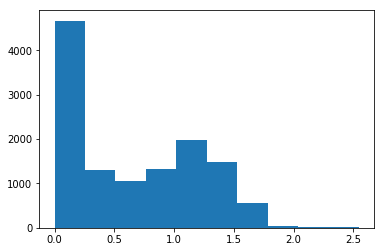

In [272]:
plt.hist(predictions[1])

(array([2138.,  764.,  699.,  513.,  949., 4747., 2188.,  371.,   49.,
          16.]),
 array([0.        , 0.22749281, 0.45498562, 0.6824784 , 0.90997124,
        1.137464  , 1.3649569 , 1.5924497 , 1.8199425 , 2.0474353 ,
        2.274928  ], dtype=float32),
 <a list of 10 Patch objects>)

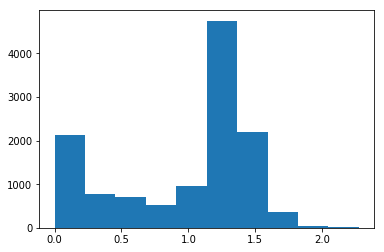

In [273]:
plt.hist(predictions[2])

In [37]:
y_valid.loc[:,"on_off_pred"] =  predictions[0].reshape(-1)

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [41]:
y_valid.loc[:,"dys_pred"]=  predictions[1].reshape(-1)

In [47]:
y_valid.loc[:,"trem_pred"]=  predictions[2].reshape(-1)

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [40]:
y_valid[["measurement_id", "on_off", "on_off_pred"]].groupby("measurement_id").mean()

,on_off,on_off_pred
measurement_id,,
0159954c-1bd2-47a6-9e6f-94f8d179b712,0.0,0.683812
026064df-af76-4b9f-b7b0-99f5bb6175ad,4.0,0.915396
046c7976-ca14-4a6c-8a58-3e6e80b26bbf,2.0,1.317221
05a3b9dd-bbe4-4c4d-8571-1c692640aead,0.0,0.685314
062754c2-b933-4307-a500-863ffdf6bebb,3.0,1.210543
06825584-d42a-46d2-804c-7ad75b2304c8,1.0,1.151944
06e3ae00-795a-4c42-bf37-9d9269dea7c0,0.0,1.469267
083e96ba-83cc-439d-9da0-c7691f635f7b,1.0,1.558910
09cb85b9-9850-42de-9422-1511948e8e80,3.0,1.549746


In [42]:
y_valid.columns

Index(['level_0', 'index', 'measurement_id', 'subject_id', 'on_off',
       'dyskinesia', 'tremor', 'Age', 'Gender', 'UPDRS_PartI_Total',
       'UPDRS_PartII_Total', 'UPDRS_4.1', 'UPDRS_4.2', 'UPDRS_4.3',
       'UPDRS_4.4', 'UPDRS_4.5', 'UPDRS_4.6', 'on_off_pred', 'dys_pred'],
      dtype='object')

In [43]:
y_valid[["measurement_id", "dyskinesia", "dys_pred"]].groupby("measurement_id").mean()

,dyskinesia,dys_pred
measurement_id,,
0159954c-1bd2-47a6-9e6f-94f8d179b712,0.0,0.033895
026064df-af76-4b9f-b7b0-99f5bb6175ad,0.0,0.127404
046c7976-ca14-4a6c-8a58-3e6e80b26bbf,2.0,0.973406
05a3b9dd-bbe4-4c4d-8571-1c692640aead,0.0,0.008221
062754c2-b933-4307-a500-863ffdf6bebb,0.0,0.659635
06825584-d42a-46d2-804c-7ad75b2304c8,0.0,0.553993
06e3ae00-795a-4c42-bf37-9d9269dea7c0,0.0,1.178702
083e96ba-83cc-439d-9da0-c7691f635f7b,0.0,1.239369
09cb85b9-9850-42de-9422-1511948e8e80,1.0,1.134460


In [45]:
import seaborn as sns

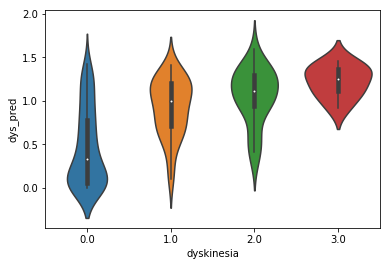

In [46]:
sns.violinplot(x="dyskinesia", y="dys_pred", data=y_valid[["measurement_id", "dyskinesia", "dys_pred"]].groupby("measurement_id").mean())

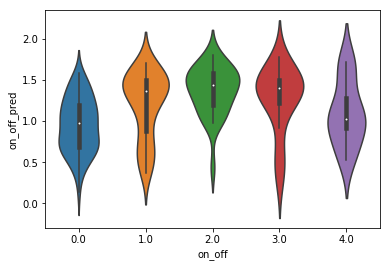

In [49]:
sns.violinplot(x="on_off", y="on_off_pred", data=y_valid[["measurement_id", "on_off", "on_off_pred"]].groupby("measurement_id").mean())

In [51]:
tmp = y_valid[["measurement_id", "dyskinesia", "dys_pred"]].groupby("measurement_id").mean()

In [53]:
((tmp.dyskinesia-tmp.dys_pred)**2).mean()

0.5668351230541496

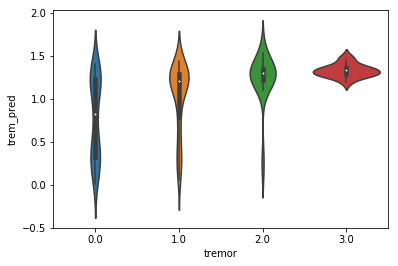

In [48]:
sns.violinplot(x="tremor", y="trem_pred", data=y_valid[["measurement_id", "tremor", "trem_pred"]].groupby("measurement_id").mean())

## run on cispd eval set

In [82]:
allResults = pkl.load( open("/n/scratch2/ms994/cispdEvalset.pkl", "rb"))

In [84]:
x = np.array([res[0] for res in allResults])

In [105]:
y = [res[1] for res in allResults]

In [106]:
len(y)

68136

In [108]:
y = np.array(y)

In [88]:
x_std = x.std(axis=1)

In [89]:
x_std = np.nan_to_num(x_std)

In [91]:
mask = ~((x_std < 0.05).all(1))

In [15]:
x[mask].shape

(65545, 1501, 3)

In [93]:
x = x[mask]

In [109]:
y = y[mask]

In [96]:
x = x[:,:1500]

In [97]:
model = keras.models.load_model("/n/scratch2/ms994/cnnlstm3.h5")

In [100]:
y_pred = model.predict(x)

In [111]:
len(x), len(y), len(y_pred)

(42718, 42718, 3)

In [115]:
y_pred = pd.DataFrame(np.array(y_pred).reshape(3,-1))

In [118]:
y_pred = y_pred.T

In [120]:
y_pred.columns = ["on_off", "dyskinesia", "tremor"]

In [132]:
m_id = [y_sing[-40:-4] for y_sing in y]

In [133]:
y_pred.loc[:, "m_id"] = m_id

In [136]:
y_pred.groupby("m_id").mean().to_csv("/home/ms994/cispd_pred.csv")

# train on realpd

In [168]:
allResults = pkl.load(open("/n/scratch2/ms994/realPDdata.pkl", "rb"))

In [192]:
import pandas as pd
from sklearn.model_selection import train_test_split
labels =  pd.read_csv("/home/ms994/beat_pd/data/real-pd/data_labels/REAL-PD_Training_Data_IDs_Labels.csv")

In [194]:
train_mid, test_mid = train_test_split(labels.measurement_id.unique(), random_state=1)

In [195]:
train_mid, valid_mid = train_test_split(train_mid, random_state=1)

In [196]:
all_mid = sorted(labels.measurement_id)

In [197]:
train_indices  = [all_mid.index(train_m) for train_m in train_mid]
valid_indices  = [all_mid.index(train_m) for train_m in valid_mid]
test_indices  = [all_mid.index(train_m) for train_m in test_mid]

In [198]:
x = np.array([res[0] for res in allResults])

In [199]:
y = [res[1] for res in allResults]

In [200]:
y = pd.concat(y)

In [201]:
x_std = x.std(axis=1)

In [202]:
x_std = np.nan_to_num(x_std)

In [203]:
mask = ~(pd.isnull(y["tremor"]) | pd.isnull(y["dyskinesia"]) | pd.isnull(y["on_off"]) | (x_std < 0.05).all(1))

In [204]:
x.shape

(58478, 1501, 3)

In [205]:
x[mask].shape

(4427, 1501, 3)

In [206]:
x = x[mask]

In [207]:
y = y[mask]

In [208]:
x = x[:,:1500]

In [209]:
all_m_id = sorted(y.measurement_id.unique())

In [210]:
train_mask = y.measurement_id.isin(train_mid) 

In [211]:
y_train = y[train_mask]

In [212]:
x_train = x[train_mask]

In [213]:
x_train.shape

(2131, 1500, 3)

In [214]:
valid_mask = y.measurement_id.isin(valid_mid)

In [215]:
y_valid = y[valid_mask]
x_valid = x[valid_mask]

## train on realpd

In [216]:
import keras
num_cnn_layers = 5
num_lstm_layers = 1
num_lin_layers = 2
inputLayer = keras.layers.Input((1500, 3))
x = inputLayer


for i in range(num_cnn_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(16, (3,), padding="same")(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool1D((2,))(x)
for j in range(num_lstm_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.CuDNNLSTM(256, return_sequences=True)(x)
    x = keras.layers.LeakyReLU()(x)


x = keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x = keras.layers.Dense(200)(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.5)(x)

x_shared_flattened = x

#one_off
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(256)(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1)(x)
x_on_off = keras.layers.ReLU(name="on_off", max_value=4)(x)

#tremor
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(100)(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1)(x)
x_dyskinesia = keras.layers.ReLU(name="dyskinesia", max_value=4)(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(100)(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1)(x)
x_tremor = keras.layers.ReLU(name="tremor", max_value=4)(x)



model = keras.Model(inputs=inputLayer, outputs=[x_on_off, x_dyskinesia, x_tremor])

In [217]:
model.compile("adam", loss=["mean_squared_error", "mean_squared_error","mean_squared_error", ])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
batch_normalization_93 (BatchNo (None, 1500, 3)      12          input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_56 (Conv1D)              (None, 1500, 16)     160         batch_normalization_93[0][0]     
__________________________________________________________________________________________________
leaky_re_lu_104 (LeakyReLU)     (None, 1500, 16)     0           conv1d_56[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [28]:
def train_gen():
    i = 0
    total_num_instances = x_train.shape[0]
    while True:
        yield x_train[i], y_train.on_off.values[i]

In [218]:
modelCheckpoint = keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/realpd_cnnlstm3.h5", save_best_only=True, verbose=True)
reduceLR = keras.callbacks.ReduceLROnPlateau(patience=5, verbose=True)
earlyStopping = keras.callbacks.EarlyStopping(patience=20, min_delta=0.01)
lr_schedule = keras.callbacks.LearningRateScheduler(lambda i, lr: lr*0.8)
history = model.fit(x=x_train, y=[y_train.on_off.values, y_train.dyskinesia.values, y_train.tremor.values], validation_data=(x_valid, [y_valid.on_off.values, y_valid.dyskinesia.values,y_valid.tremor.values]), callbacks=[earlyStopping, lr_schedule, modelCheckpoint], epochs=200, batch_size=128)

Train on 2131 samples, validate on 685 samples
Epoch 1/200
2131/2131 [==============================] - 31s 14ms/step - loss: 1.9349 - on_off_loss: 0.6078 - dyskinesia_loss: 0.4951 - tremor_loss: 0.8320 - val_loss: 2.0685 - val_on_off_loss: 0.4907 - val_dyskinesia_loss: 0.2545 - val_tremor_loss: 1.3233

Epoch 00001: val_loss improved from inf to 2.06846, saving model to /n/scratch2/ms994/realpd_cnnlstm3.h5
Epoch 2/200
2131/2131 [==============================] - 1s 579us/step - loss: 1.3362 - on_off_loss: 0.3937 - dyskinesia_loss: 0.3140 - tremor_loss: 0.6284 - val_loss: 2.0636 - val_on_off_loss: 0.4858 - val_dyskinesia_loss: 0.2586 - val_tremor_loss: 1.3192

Epoch 00002: val_loss improved from 2.06846 to 2.06357, saving model to /n/scratch2/ms994/realpd_cnnlstm3.h5
Epoch 3/200
2131/2131 [==============================] - 1s 537us/step - loss: 1.1551 - on_off_loss: 0.3716 - dyskinesia_loss: 0.2506 - tremor_loss: 0.5329 - val_loss: 2.0653 - val_on_off_loss: 0.4892 - val_dyskinesia_loss:

## run on realpd eval set

In [219]:
model = keras.models.load_model("/n/scratch2/ms994/realpd_cnnlstm3.h5")

In [220]:
allResults = pkl.load( open("/n/scratch2/ms994/realpdEvalset.pkl", "rb"))

In [221]:
x = np.array([res[0] for res in allResults])

In [222]:
y = [res[1] for res in allResults]

In [223]:
y = np.array(y)

In [224]:
x_std = x.std(axis=1)

In [225]:
x_std = np.nan_to_num(x_std)

In [226]:
mask = ~((x_std < 0.05).all(1))

In [227]:
x.shape

(19071, 1501, 3)

In [228]:
x[mask].shape

(16071, 1501, 3)

In [229]:
x = x[mask]

In [230]:
y = y[mask]

In [231]:
x = x[:,:1500]

In [232]:
y_pred = model.predict(x)

In [233]:
x.shape, y.shape

((16071, 1500, 3), (16071,))

In [234]:
y_pred = pd.DataFrame(np.array(y_pred).reshape(3,-1))

In [235]:
y_pred = y_pred.T

In [236]:
y_pred.shape

(16071, 3)

In [237]:
y_pred.columns = ["on_off", "dyskinesia", "tremor"]

In [238]:
m_id =  [y_sing[-40:-4] for y_sing in y]

In [239]:
y_pred.loc[:, "m_id"] = m_id

In [240]:
y_pred.groupby("m_id").mean().to_csv("/home/ms994/realpd_pred.csv")

# dyskinesia only

In [75]:
import keras
num_cnn_layers = 5
num_lstm_layers = 1
num_lin_layers = 2
inputLayer = keras.layers.Input((1500, 3))
x = inputLayer


for i in range(num_cnn_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(16, (3,), padding="same")(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool1D((2,))(x)
for j in range(num_lstm_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.CuDNNLSTM(256, return_sequences=True)(x)
    x = keras.layers.LeakyReLU()(x)


x = keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x = keras.layers.Dense(200)(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.5)(x)

x_shared_flattened = x

#tremor
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(100)(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1)(x)
x_dyskinesia = keras.layers.ReLU(name="dyskinesia", max_value=4)(x)



model = keras.Model(inputs=inputLayer, outputs=x_dyskinesia)
model.compile("adam", loss="mean_squared_error")

In [76]:
modelCheckpoint = keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnnlstm3_dysk_only.h5", save_best_only=True, verbose=True)
reduceLR = keras.callbacks.ReduceLROnPlateau(patience=5, verbose=True)
earlyStopping = keras.callbacks.EarlyStopping(patience=20, min_delta=0.01)
lr_schedule = keras.callbacks.LearningRateScheduler(lambda i, lr: lr*0.8)
history = model.fit(x=x_train, y=y_train.dyskinesia.values, validation_data=(x_valid,  y_valid.dyskinesia.values), callbacks=[earlyStopping, lr_schedule, modelCheckpoint], epochs=200, batch_size=128)

Train on 36987 samples, validate on 12434 samples
Epoch 1/200
36987/36987 [==============================] - 31s 842us/step - loss: 1.0463 - val_loss: 0.6559

Epoch 00001: val_loss improved from inf to 0.65589, saving model to /n/scratch2/ms994/cnnlstm3_dysk_only.h5
Epoch 2/200
36987/36987 [==============================] - 16s 421us/step - loss: 0.8198 - val_loss: 0.6373

Epoch 00002: val_loss improved from 0.65589 to 0.63734, saving model to /n/scratch2/ms994/cnnlstm3_dysk_only.h5
Epoch 3/200
36987/36987 [==============================] - 15s 419us/step - loss: 0.7844 - val_loss: 0.6280

Epoch 00003: val_loss improved from 0.63734 to 0.62795, saving model to /n/scratch2/ms994/cnnlstm3_dysk_only.h5
Epoch 4/200
36987/36987 [==============================] - 16s 421us/step - loss: 0.7515 - val_loss: 0.6190

Epoch 00004: val_loss improved from 0.62795 to 0.61899, saving model to /n/scratch2/ms994/cnnlstm3_dysk_only.h5
Epoch 5/200
36987/36987 [==============================] - 16s 420us/s

In [58]:
model = keras.models.load_model("/n/scratch2/ms994/cnnlstm3_dysk_only.h5")

In [59]:
y_pred_dysk_only = model.predict(x_valid)

In [60]:
y_pred_dysk_only = y_pred_dysk_only.reshape(-1)

In [62]:
y_valid.loc[:, "y_pred_dysk_only"] = y_pred_dysk_only

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [65]:
temp = y_valid[["measurement_id","dyskinesia", "y_pred_dysk_only"]].groupby("measurement_id").mean()

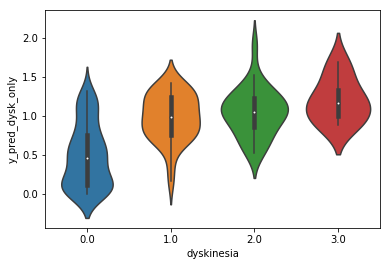

In [66]:
sns.violinplot("dyskinesia", "y_pred_dysk_only", data=temp)

# tremor only

In [77]:
import keras
num_cnn_layers = 5
num_lstm_layers = 1
num_lin_layers = 2
inputLayer = keras.layers.Input((1500, 3))
x = inputLayer


for i in range(num_cnn_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(16, (3,), padding="same")(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool1D((2,))(x)
for j in range(num_lstm_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.CuDNNLSTM(256, return_sequences=True)(x)
    x = keras.layers.LeakyReLU()(x)


x = keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x = keras.layers.Dense(200)(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.5)(x)

x_shared_flattened = x

#tremor
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(100)(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1)(x)
x_dyskinesia = keras.layers.ReLU(name="tremor", max_value=4)(x)



model = keras.Model(inputs=inputLayer, outputs=x_dyskinesia)
model.compile("adam", loss="mean_squared_error")

In [78]:
modelCheckpoint = keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnnlstm3_tremor_only.h5", save_best_only=True, verbose=True)
reduceLR = keras.callbacks.ReduceLROnPlateau(patience=5, verbose=True)
earlyStopping = keras.callbacks.EarlyStopping(patience=20, min_delta=0.01)
lr_schedule = keras.callbacks.LearningRateScheduler(lambda i, lr: lr*0.8)
history = model.fit(x=x_train, y=y_train.tremor.values, validation_data=(x_valid,  y_valid.tremor.values), callbacks=[earlyStopping, lr_schedule, modelCheckpoint], epochs=200, batch_size=128)

Train on 36987 samples, validate on 12434 samples
Epoch 1/200
36987/36987 [==============================] - 32s 871us/step - loss: 1.0639 - val_loss: 0.7481

Epoch 00001: val_loss improved from inf to 0.74813, saving model to /n/scratch2/ms994/cnnlstm3_tremor_only.h5
Epoch 2/200
36987/36987 [==============================] - 16s 421us/step - loss: 0.8537 - val_loss: 0.7337

Epoch 00002: val_loss improved from 0.74813 to 0.73374, saving model to /n/scratch2/ms994/cnnlstm3_tremor_only.h5
Epoch 3/200
36987/36987 [==============================] - 16s 422us/step - loss: 0.8282 - val_loss: 0.7333

Epoch 00003: val_loss improved from 0.73374 to 0.73325, saving model to /n/scratch2/ms994/cnnlstm3_tremor_only.h5
Epoch 4/200
36987/36987 [==============================] - 16s 419us/step - loss: 0.7883 - val_loss: 0.7258

Epoch 00004: val_loss improved from 0.73325 to 0.72584, saving model to /n/scratch2/ms994/cnnlstm3_tremor_only.h5
Epoch 5/200
36987/36987 [==============================] - 16s

# on off only

In [79]:
import keras
num_cnn_layers = 5
num_lstm_layers = 1
num_lin_layers = 2
inputLayer = keras.layers.Input((1500, 3))
x = inputLayer


for i in range(num_cnn_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(16, (3,), padding="same")(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool1D((2,))(x)
for j in range(num_lstm_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.CuDNNLSTM(256, return_sequences=True)(x)
    x = keras.layers.LeakyReLU()(x)


x = keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x = keras.layers.Dense(200)(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.5)(x)

x_shared_flattened = x

#tremor
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(100)(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1)(x)
x_dyskinesia = keras.layers.ReLU(name="on_off", max_value=4)(x)



model = keras.Model(inputs=inputLayer, outputs=x_dyskinesia)
model.compile("adam", loss="mean_squared_error")

In [80]:
modelCheckpoint = keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnnlstm3_on_off_only.h5", save_best_only=True, verbose=True)
reduceLR = keras.callbacks.ReduceLROnPlateau(patience=5, verbose=True)
earlyStopping = keras.callbacks.EarlyStopping(patience=20, min_delta=0.01)
lr_schedule = keras.callbacks.LearningRateScheduler(lambda i, lr: lr*0.8)
history = model.fit(x=x_train, y=y_train.on_off.values, validation_data=(x_valid,  y_valid.on_off.values), callbacks=[earlyStopping, lr_schedule, modelCheckpoint], epochs=200, batch_size=128)

Train on 36987 samples, validate on 12434 samples
Epoch 1/200
36987/36987 [==============================] - 33s 895us/step - loss: 2.0171 - val_loss: 1.7679

Epoch 00001: val_loss improved from inf to 1.76787, saving model to /n/scratch2/ms994/cnnlstm3_on_off_only.h5
Epoch 2/200
36987/36987 [==============================] - 16s 427us/step - loss: 1.7857 - val_loss: 1.8170

Epoch 00002: val_loss did not improve from 1.76787
Epoch 3/200
36987/36987 [==============================] - 15s 419us/step - loss: 1.8647 - val_loss: 1.8639

Epoch 00003: val_loss did not improve from 1.76787
Epoch 4/200
36987/36987 [==============================] - 16s 421us/step - loss: 1.7541 - val_loss: 1.7500

Epoch 00004: val_loss improved from 1.76787 to 1.74995, saving model to /n/scratch2/ms994/cnnlstm3_on_off_only.h5
Epoch 5/200
36987/36987 [==============================] - 16s 422us/step - loss: 1.8486 - val_loss: 1.7184

Epoch 00005: val_loss improved from 1.74995 to 1.71843, saving model to /n/scra

# Homeoschedastic

In [28]:
len(labels.subject_id.unique())

16

In [29]:

from keras.layers import Input, Dense, Lambda, Layer
from keras.initializers import Constant
from keras.models import Model
from keras import backend as K

# Custom loss layer
class CustomMultiLossLayer(Layer):
    def __init__(self, nb_outputs=2, **kwargs):
        self.nb_outputs = nb_outputs
        self.is_placeholder = True
        super(CustomMultiLossLayer, self).__init__(**kwargs)
        
    def build(self, input_shape=None):
        # initialise log_vars
        self.log_vars = []
        for i in range(self.nb_outputs):
            self.log_vars += [self.add_weight(name='log_var' + str(i), shape=(1,),
                                              initializer=Constant(0.), trainable=True)]
        super(CustomMultiLossLayer, self).build(input_shape)

    def multi_loss(self, ys_true, ys_pred):
        assert len(ys_true) == self.nb_outputs and len(ys_pred) == self.nb_outputs
        loss = 0
        for y_true, y_pred, log_var in zip(ys_true, ys_pred, self.log_vars):
            precision = K.exp(-log_var[0])
            loss += K.sum(precision * (y_true - y_pred)**2. + log_var[0], -1)
        return K.mean(loss)

    def call(self, inputs):
        ys_true = inputs[:self.nb_outputs]
        ys_pred = inputs[self.nb_outputs:]
        loss = self.multi_loss(ys_true, ys_pred)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return K.concatenate(inputs, -1)

Using TensorFlow backend.


In [33]:
import keras
num_cnn_layers = 5
num_lstm_layers = 1
num_lin_layers = 2
inputLayer = keras.layers.Input((1500, 3))
x = inputLayer


for i in range(num_cnn_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(16, (3,), padding="same")(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool1D((2,))(x)
for j in range(num_lstm_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.CuDNNLSTM(256, return_sequences=True)(x)
    x = keras.layers.LeakyReLU()(x)


x = keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x = keras.layers.Dense(200)(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.5)(x)

x_shared_flattened = x

#one_off
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(256)(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1)(x)
x_on_off = keras.layers.ReLU(name="on_off", max_value=4)(x)
x_on_off_input = keras.layers.Input((1,))

#dyskinesia
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(100)(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1)(x)
x_dyskinesia = keras.layers.ReLU(name="dyskinesia", max_value=4)(x)
x_dyskinesia_input = keras.layers.Input((1,))

#tremor classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(100)(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1)(x)
x_tremor = keras.layers.ReLU(name="tremor", max_value=4)(x)
x_tremor_input = keras.layers.Input((1,))


x = CustomMultiLossLayer(nb_outputs=3)([x_on_off, x_dyskinesia, x_tremor, x_on_off_input, x_tremor_input, x_dyskinesia_input])
model = keras.Model(inputs=[inputLayer, x_on_off_input, x_tremor_input, x_dyskinesia_input], outputs=x)
actual_model = keras.Model(inputs=inputLayer, outputs=[x_on_off, x_dyskinesia, x_tremor])

In [34]:
model.compile("adam", loss=None)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 1500, 3)      12          input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 1500, 16)     160         batch_normalization_21[0][0]     
__________________________________________________________________________________________________
leaky_re_lu_23 (LeakyReLU)      (None, 1500, 16)     0           conv1d_11[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [36]:
modelCheckpoint = keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnnlstm3.h5", save_best_only=True, verbose=True)
reduceLR = keras.callbacks.ReduceLROnPlateau(patience=5, verbose=True)
earlyStopping = keras.callbacks.EarlyStopping(patience=20, min_delta=0.01)
lr_schedule = keras.callbacks.LearningRateScheduler(lambda i, lr: lr*0.8)
history = model.fit(x=[x_train, y_train.on_off.values, y_train.dyskinesia.values, y_train.tremor.values], validation_data=([[x_valid, y_valid.on_off.values, y_valid.dyskinesia.values,y_valid.tremor.values],[]]), callbacks=[earlyStopping, lr_schedule, modelCheckpoint], epochs=200, batch_size=128)

Instructions for updating:
Use tf.cast instead.
Train on 36987 samples, validate on 12434 samples
Epoch 1/200
36987/36987 [==============================] - 36s 967us/step - loss: 3.9081 - val_loss: 3.1129

Epoch 00001: val_loss improved from inf to 3.11286, saving model to /n/scratch2/ms994/cnnlstm3.h5
Epoch 2/200
36987/36987 [==============================] - 11s 306us/step - loss: 3.3946 - val_loss: 3.1701

Epoch 00002: val_loss did not improve from 3.11286
Epoch 3/200
36987/36987 [==============================] - 11s 305us/step - loss: 3.3059 - val_loss: 2.9197

Epoch 00003: val_loss improved from 3.11286 to 2.91972, saving model to /n/scratch2/ms994/cnnlstm3.h5
Epoch 4/200
36987/36987 [==============================] - 11s 307us/step - loss: 3.1170 - val_loss: 2.8658

Epoch 00004: val_loss improved from 2.91972 to 2.86579, saving model to /n/scratch2/ms994/cnnlstm3.h5
Epoch 5/200
36987/36987 [==============================] - 11s 308us/step - loss: 3.0527 - val_loss: 2.8392

Epoc

In [37]:
y_pred = model.predict(x_valid)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 4 array(s), but instead got the following list of 1 arrays: [array([[[-1.00231932e+00,  7.67822265e-02,  1.69311525e-01],
        [-1.06408690e+00,  4.05273450e-02,  2.78564455e-01],
        [-1.00964354e+00, -3.22265630e-02,  3.40942385e-01],
        ...,
   ...